In [1]:
import spikeinterface.full as si
import numpy as np
import pandas as pd
from pathlib import Path
from spikeinterface.generation.drift_tools import DriftingTemplates, interpolate_templates, InjectDriftingTemplatesRecording
import pickle
import matplotlib.pyplot as plt
import scipy
from ibldsp.utils import make_channel_index
from neuropixel import trace_header
import dartsort
from dartsort.util.hybrid_util import refractory_poisson_spike_train, get_drifty_hybrid_recording
from dartsort.util.data_util import DARTsortSorting
from spikeinterface.extractors import NumpySorting
from spikeinterface.core import Templates

In [2]:

### RE recordings (destriped)

pids = [
        "1e176f17-d00f-49bb-87ff-26d237b525f1",
        "8ca1a850-26ef-42be-8b28-c2e2d12f06d6",
        "c4f6665f-8be5-476b-a6e8-d81eeae9279d",
        "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
        "e31b4e39-e350-47a9-aca4-72496d99ff2a",
       ]

def rec_from_pid(pid):
    recordings_path = Path("/expanse/lustre/projects/col168/cwindolf/rs_f16")
    ppath = recordings_path.joinpath(pid)
    return si.read_binary_folder(ppath)

In [3]:
### RE templates


temp_pids = ['1a60a6e1-da99-4d4e-a734-39b1d4544fad',
 'bbe6ebc1-d32f-42dd-a89c-211226737deb',
 '84fd7fa3-6c2d-4233-b265-46a427d3d68d',
 'dab512bd-a02d-4c1f-8dbc-9155a163efc0',
 '6fc4d73c-2071-43ec-a756-c6c6d8322c8b',
 '1f5d62cb-814f-4ab2-b6af-7557ea04d56a',
 '8ca1a850-26ef-42be-8b28-c2e2d12f06d6',
 'ad714133-1e03-4d3a-8427-33fc483daf1a',
 'c17772a9-21b5-49df-ab31-3017addea12e',
 'ce397420-3cd2-4a55-8fd1-5e28321981f4',
 '7a620688-66cb-44d3-b79b-ccac1c8ba23e']

def templates_from_pid(pid):
    templates_path = Path("/expanse/lustre/projects/col168/clangfield/data/re_templates/")
    tpath = templates_path.joinpath(pid, "templates.npy")
    z = np.load(tpath)
    return z

def template_info_from_pid(pid):
    templates_path = Path("/expanse/lustre/projects/col168/clangfield/data/re_templates/")
    tpath = templates_path.joinpath(pid, "templates.npy")
    t = pd.read_parquet(templates_path.joinpath(pid, "template_info.pqt"))
    df = pd.DataFrame(t.groupby("cluster").agg(num_wfs=("sample", "count"), peak_channel=("peak_channel", pd.Series.mode)))
    df.rename(columns = {"sample": "num_wfs"}, inplace=True)
    df["peak_channel"] = df["peak_channel"].astype(int)
    return df

In [4]:
### Motion estimates


motion_pids = ["1e176f17-d00f-49bb-87ff-26d237b525f1",
        "8ca1a850-26ef-42be-8b28-c2e2d12f06d6",
        "c4f6665f-8be5-476b-a6e8-d81eeae9279d",
        "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
        "e31b4e39-e350-47a9-aca4-72496d99ff2a",
]

def motion_est_from_pid(pid):
    motion_path = Path("/expanse/lustre/projects/col168/cwindolf/rs_hybrid/original_thresholding")
    ppath = motion_path.joinpath(pid, "motion_est.pkl")
    with open(ppath, 'rb') as f:
        x = pickle.load(f)
    return x


In [5]:
### Start analysis

# pids we have preprocessed data for and motion est for 
pids_use = sorted(list(set(pids).intersection(set(motion_pids))))

In [6]:
### Create drifty templates
pid = pids_use[0]
seed = int(f"0x{pid.split('-')[0]}", 0)

output_dir = Path(f"/expanse/lustre/projects/col168/clangfield/data/re_hybrid/{pid}")
output_dir.mkdir(exist_ok=True)

print(pid, seed)

templates = templates_from_pid(temp_pids[0])
templates_info = template_info_from_pid(temp_pids[0])
me = motion_est_from_pid(pid)
rec = rec_from_pid(pid)


1e176f17-d00f-49bb-87ff-26d237b525f1 504852247


Text(0.5, 0.98, 'RE templates')

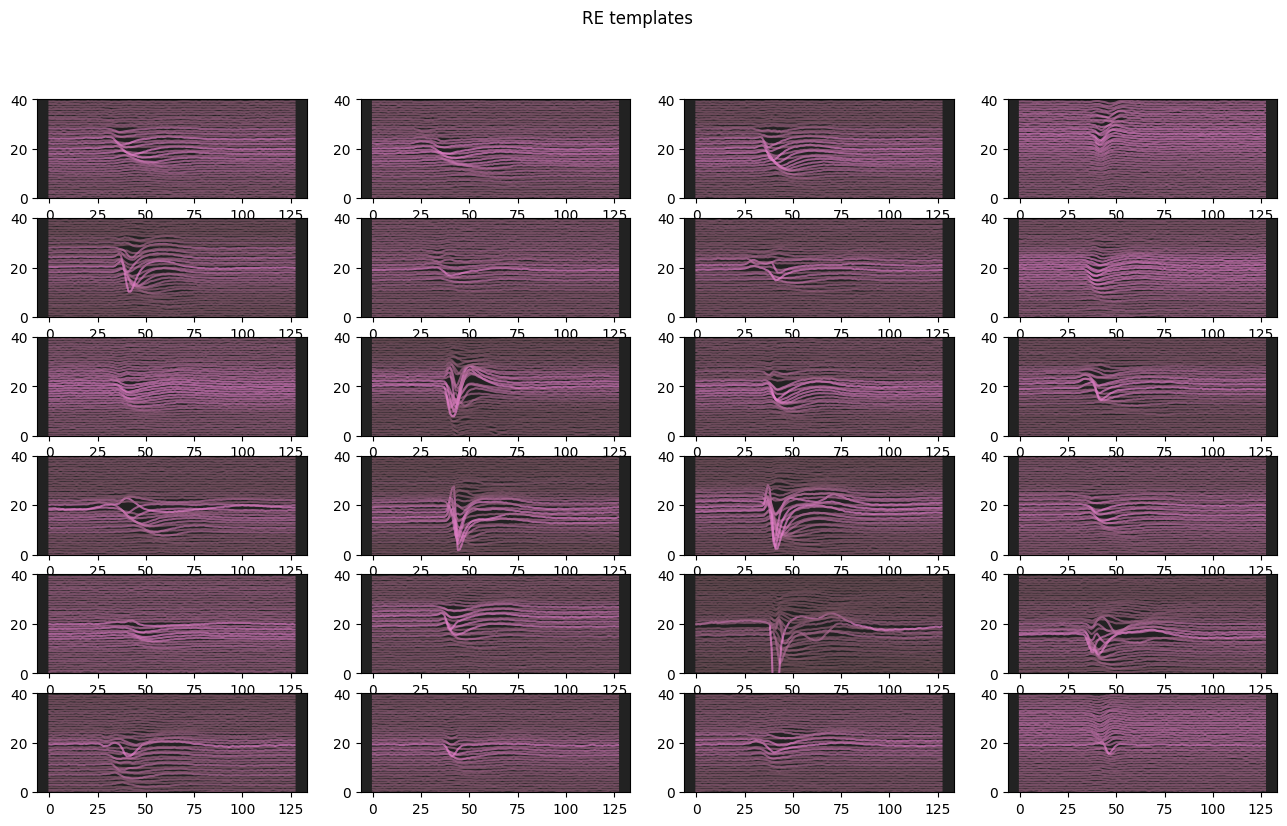

In [7]:
# look at templates

def trace_plot(arr, ax, channel_range=None, spike_range=None, title=""):
    if spike_range is None:
        spike_range = np.arange(0, 128)
    if channel_range is None:
        channel_range = np.arange(0, 40)
    ax.set_facecolor("#222")
    all_norms = np.linalg.norm(np.abs(arr[spike_range,:]), axis=0)
    max_norm = np.max(all_norms)
    all_norms = np.sqrt(all_norms / max_norm) / 2.
    for i in channel_range:
        y = i + arr[spike_range, i]
        ax.plot(spike_range, y, 
                color = 
                (0.4 + all_norms[i], 0.3 + 0.4*all_norms[i], 0.3 + all_norms[i], .7))
    ax.set_ylim(0, 40)
    ax.set_title(title)

fig, axs = plt.subplots(6, 4, figsize=(16, 9))
for i, ax in enumerate(axs.flat):
    trace_plot(1e5*templates[400+i,:,:].swapaxes(0, 1), ax)
    #fig.colorbar(im, ax=ax, label="amp (uV)")
fig.suptitle("RE templates")

In [8]:
allowed = (templates_info.num_wfs == 256) & (templates_info.peak_channel > 40) & (templates_info.peak_channel < 340)

In [9]:
# randomly select templates and make them full size

# for filling in missing channels
h = trace_header()
geom = np.c_[h["x"], h["y"]]
channel_map = make_channel_index(geom)

nt = 40
select_templates = templates_info[allowed].sample(nt, random_state=seed)
template_indices = select_templates.index.to_numpy()
templates_fullsize = np.zeros((nt, 128, 384), np.float32)
for i, idx in enumerate(template_indices):
    template_full = np.zeros((128, 384), np.float32)
    template_crop = templates[idx].swapaxes(0, 1)
    peak_chan = select_templates.loc[idx].peak_channel
    chans = channel_map[peak_chan]
    template_full[:, chans] = template_crop
    templates_fullsize[i, :, :] = template_full
print(seed)
template_indices
peak_channels = select_templates.peak_channel.to_numpy()
peak_channels

504852247


array([123,  82,  78, 109, 118, 328, 103, 122, 195, 151, 127, 323, 253,
       101,  96, 227, 266, 198,  42,  58, 270, 250,  61, 314, 318, 104,
       146, 192, 121, 271, 124,  88, 290,  51,  62,  52, 266,  54, 145,
       295])

In [10]:
# Create the Drifting Templates

# make ~20 precomputed displacements
ndsp = 5
disp = np.zeros((ndsp, 2))
disp[:, 1] = np.linspace(-50., 50., ndsp)


drifties = DriftingTemplates.from_static(Templates(templates_fullsize, rec.get_sampling_frequency(), nbefore=42, probe=rec.get_probe()))

drifties.precompute_displacements(disp)


In [11]:
# Create the hybrid recording

hybrid, sorting = get_drifty_hybrid_recording(rec, drifties, me, peak_channels=peak_channels, seed=100)


In [12]:
#hybrid.save_to_folder(Path(f"/expanse/lustre/projects/col168/clangfield/data/re_hybrid/{pid}/recording"), n_jobs=16, overwrite=True)

In [13]:
# times_samples = sorting.to_spike_vector()["sample_index"]
# labels = sorting.to_spike_vector()["unit_index"]
# channels = peak_channels[labels]
# dsorting = DARTsortSorting(times_samples=times_samples, channels=channels, labels=labels)
# dsorting.save(output_dir.joinpath("sorting.npz"))
# dsorting = DARTsortSorting.load(output_dir.joinpath("sorting.npz"))

In [14]:
sorting.register_recording(hybrid)

In [15]:
sorting.save_to_folder(output_dir.joinpath("numpy_sorting"))

Use cache_folder=/expanse/lustre/projects/col168/clangfield/data/re_hybrid/1e176f17-d00f-49bb-87ff-26d237b525f1/numpy_sorting


AssertionError: folder /expanse/lustre/projects/col168/clangfield/data/re_hybrid/1e176f17-d00f-49bb-87ff-26d237b525f1/numpy_sorting already exists, choose another name or use overwrite=True